<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importations" data-toc-modified-id="Importations-1">Importations</a></span></li><li><span><a href="#Ajout-de-colonnes-depuis-'date'" data-toc-modified-id="Ajout-de-colonnes-depuis-'date'-2">Ajout de colonnes depuis 'date'</a></span></li><li><span><a href="#Ajout-des-coordonnées" data-toc-modified-id="Ajout-des-coordonnées-3">Ajout des coordonnées</a></span></li><li><span><a href="#Regroupement-des-données" data-toc-modified-id="Regroupement-des-données-4">Regroupement des données</a></span></li><li><span><a href="#DropNA" data-toc-modified-id="DropNA-5">DropNA</a></span></li><li><span><a href="#Modèle" data-toc-modified-id="Modèle-6">Modèle</a></span></li></ul></div>

In [138]:
import numpy.linalg as npl
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape

from xgboost import XGBRegressor

# Importations

In [359]:
DATA_X = pd.read_csv("Train/Train/X_station_train.csv")
DATA_Y = pd.read_csv("Train/Train/Y_train.csv")
COORDS = pd.read_csv("Other/Other/stations_coordinates.csv")
DATA_X = pd.read_csv("polaki.csv")

In [360]:
train = DATA_X.copy()
y = DATA_Y.copy()
coords = COORDS.copy()

# Ajout de colonnes depuis 'date'

In [361]:
train["month"] = train["date"].replace(to_replace="^.{5}", value="", regex=True)\
                              .replace(to_replace=".{12}$", value="", regex=True)

train["day"] = train["date"].replace(to_replace="^.{8}", value="", regex=True)\
                            .replace(to_replace=".{9}$", value="", regex=True)

train["hour"] = train["date"].replace(to_replace="^.{11}", value="", regex=True)\
                             .replace(to_replace=".{6}$", value="", regex=True)

In [362]:
del train["date"]

In [363]:
train = train.astype({"month": "int8", "day": "int8", "hour": "int8"})

# Ajout des coordonnées

In [364]:
train = train.merge(coords, how="left", on="number_sta")

In [365]:
train = train.astype({"Id": str, 
                      "number_sta": "category", 
                      "month": "category", 
                      "day": "category", 
                      "hour": "category"})

# Regroupement des données

In [366]:
train["Id"].replace(to_replace=".\d+$", value="", regex=True, inplace=True)

In [367]:
train

,number_sta,ff,t,td,hu,dd,precip,Id,max_t,min_t,...,min_hu,mean_dd,max_precip,min_precip,month,day,hour,lat,lon,height_sta
0,14372001,3.68,279.20,277.79,90.8,230.0,0.0,14372001_0,307.48,267.94,...,24.9,205.314636,13.9,0.0,1,1,0,49.102,-0.765,184.0
1,14372001,2.99,278.86,277.57,91.5,221.0,0.0,14372001_0,307.48,267.94,...,24.9,205.314636,13.9,0.0,1,1,1,49.102,-0.765,184.0
2,14372001,2.06,278.26,277.58,95.4,204.0,0.0,14372001_0,307.48,267.94,...,24.9,205.314636,13.9,0.0,1,1,2,49.102,-0.765,184.0
3,14372001,2.14,276.89,276.43,96.7,197.0,0.0,14372001_0,307.48,267.94,...,24.9,205.314636,13.9,0.0,1,1,3,49.102,-0.765,184.0
4,14372001,2.10,276.91,276.75,98.7,184.0,0.0,14372001_0,307.48,267.94,...,24.9,205.314636,13.9,0.0,1,1,4,49.102,-0.765,184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4409469,86165005,4.11,286.12,283.48,83.8,230.0,0.0,86165005_729,311.29,265.72,...,11.4,179.069880,14.0,0.0,12,30,19,46.412,0.841,153.0
4409470,86165005,4.42,285.88,283.43,85.0,224.0,0.0,86165005_729,311.29,265.72,...,11.4,179.069880,14.0,0.0,12,30,20,46.412,0.841,153.0
4409471,86165005,4.37,285.59,283.44,86.8,213.0,0.0,86165005_729,311.29,265.72,...,11.4,179.069880,14.0,0.0,12,30,21,46.412,0.841,153.0
4409472,86165005,3.91,285.89,283.34,84.5,231.0,0.0,86165005_729,311.29,265.72,...,11.4,179.069880,14.0,0.0,12,30,22,46.412,0.841,153.0


In [369]:
train = train.groupby("Id", as_index=False).agg({
    "number_sta": "first",
    "ff": "median",
    "t": "median",
    "td": "median",
    "hu": "max",
    "dd": "median",
    "precip": "sum",
    "month": "first",
    "day": "first",
    "hour": "first",
    "lat": "first",
    "lon": "first",
    "height_sta": "first",
    "max_t": "first",
    "min_t": "first",
    "max_ff": "first",
    "min_ff": "first",
    "max_td": "first",
    "min_td": "first",
    "max_hu": "first",
    "min_hu": "first",
    "mean_dd": "first",
    "max_precip": "first",
    "min_precip": "first"
})

In [370]:
train

,Id,number_sta,ff,t,td,hu,dd,precip,month,day,...,min_t,max_ff,min_ff,max_td,min_td,max_hu,min_hu,mean_dd,max_precip,min_precip
0,14066001_0,14066001,3.695,281.325,278.625,98.1,142.0,0.2,1,1,...,267.91,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0
1,14066001_1,14066001,7.690,282.870,280.045,92.0,207.0,3.4,1,2,...,267.91,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0
2,14066001_10,14066001,5.340,279.520,277.385,92.6,226.5,6.0,1,11,...,267.91,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0
3,14066001_100,14066001,4.435,283.950,278.005,90.3,133.0,11.6,4,10,...,267.91,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0
4,14066001_101,14066001,1.790,282.720,281.360,95.2,171.5,5.6,4,11,...,267.91,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183742,95690001_725,95690001,7.310,279.005,276.850,92.3,202.0,2.4,12,26,...,265.88,18.35,0.0,296.69,264.61,99.1,27.4,197.831728,17.5,0.0
183743,95690001_726,95690001,8.285,277.110,274.885,93.0,276.5,3.2,12,27,...,265.88,18.35,0.0,296.69,264.61,99.1,27.4,197.831728,17.5,0.0
183744,95690001_727,95690001,2.875,274.495,273.055,93.4,250.5,0.0,12,28,...,265.88,18.35,0.0,296.69,264.61,99.1,27.4,197.831728,17.5,0.0
183745,95690001_728,95690001,6.545,278.760,275.480,95.8,210.0,4.4,12,29,...,265.88,18.35,0.0,296.69,264.61,99.1,27.4,197.831728,17.5,0.0


In [371]:
y.sort_values("Id")

,date,number_sta,Ground_truth,Id
0,2016-01-02,14066001,3.4,14066001_0
249,2016-01-03,14066001,11.7,14066001_1
2491,2016-01-12,14066001,1.0,14066001_10
24978,2016-04-11,14066001,5.6,14066001_100
25228,2016-04-12,14066001,3.2,14066001_101
...,...,...,...,...
182747,2017-12-27,95690001,3.2,95690001_725
182997,2017-12-28,95690001,0.0,95690001_726
183247,2017-12-29,95690001,4.4,95690001_727
183497,2017-12-30,95690001,5.4,95690001_728


# DropNA

In [372]:
y_train = y.dropna()

In [373]:
train_ = train[train["Id"].isin(y_train["Id"])]

In [374]:
train_.set_index("Id", inplace=True)
y_train.set_index("Id", inplace=True)

In [375]:
#y_train = y_train["Ground_truth"]
data = train_.merge(y_train[["Ground_truth"]], on="Id")

data["Ground_truth"] = data["Ground_truth"].shift(1, fill_value=0)

In [376]:
data

,number_sta,ff,t,td,hu,dd,precip,month,day,hour,...,max_ff,min_ff,max_td,min_td,max_hu,min_hu,mean_dd,max_precip,min_precip,Ground_truth
Id,,,,,,,,,,,,,,,,,,,,,
14066001_0,14066001,3.695,281.325,278.625,98.1,142.0,0.2,1,1,0,...,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0,0.0
14066001_1,14066001,7.690,282.870,280.045,92.0,207.0,3.4,1,2,0,...,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0,3.4
14066001_10,14066001,5.340,279.520,277.385,92.6,226.5,6.0,1,11,0,...,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0,11.7
14066001_100,14066001,4.435,283.950,278.005,90.3,133.0,11.6,4,10,0,...,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0,1.0
14066001_101,14066001,1.790,282.720,281.360,95.2,171.5,5.6,4,11,0,...,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95690001_725,95690001,7.310,279.005,276.850,92.3,202.0,2.4,12,26,0,...,18.35,0.0,296.69,264.61,99.1,27.4,197.831728,17.5,0.0,2.4
95690001_726,95690001,8.285,277.110,274.885,93.0,276.5,3.2,12,27,0,...,18.35,0.0,296.69,264.61,99.1,27.4,197.831728,17.5,0.0,3.2
95690001_727,95690001,2.875,274.495,273.055,93.4,250.5,0.0,12,28,0,...,18.35,0.0,296.69,264.61,99.1,27.4,197.831728,17.5,0.0,0.0


# Modèle

In [377]:
X = data.drop("Ground_truth", axis=1)
features_name = X.columns
Y = data["Ground_truth"]

In [378]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=42)
X_train = pd.DataFrame(X_train, columns=features_name)

In [379]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_mean=True)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [402]:
my_xgbr = XGBRegressor()

In [403]:
my_xgbr.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [404]:
pred = my_xgbr.predict(X_test)

In [405]:
mape(pred, Y_test)

1.3336632654223401

In [397]:
l = []
i = 0
for col,score in zip(features_name, my_xgbr.feature_importances_):
    l.append([col,score])
    i += 1

l.sort(key=lambda x: x[1])
l

[['min_precip', 0.0],
 ['hour', 0.0026263152],
 ['min_ff', 0.008558506],
 ['number_sta', 0.010323708],
 ['max_hu', 0.010747863],
 ['ff', 0.010780544],
 ['max_td', 0.011435347],
 ['min_td', 0.011827807],
 ['hu', 0.011886462],
 ['min_hu', 0.012025684],
 ['max_precip', 0.012495893],
 ['max_ff', 0.013405349],
 ['height_sta', 0.017869372],
 ['mean_dd', 0.017900633],
 ['min_t', 0.01919603],
 ['dd', 0.019348737],
 ['max_t', 0.020885035],
 ['lon', 0.022886718],
 ['td', 0.023365254],
 ['lat', 0.02640956],
 ['t', 0.038932767],
 ['day', 0.061614804],
 ['month', 0.11673982],
 ['precip', 0.4987378]]

In [385]:
data

,number_sta,ff,t,td,hu,dd,precip,month,day,hour,...,max_ff,min_ff,max_td,min_td,max_hu,min_hu,mean_dd,max_precip,min_precip,Ground_truth
Id,,,,,,,,,,,,,,,,,,,,,
14066001_0,14066001,3.695,281.325,278.625,98.1,142.0,0.2,1,1,0,...,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0,0.0
14066001_1,14066001,7.690,282.870,280.045,92.0,207.0,3.4,1,2,0,...,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0,3.4
14066001_10,14066001,5.340,279.520,277.385,92.6,226.5,6.0,1,11,0,...,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0,11.7
14066001_100,14066001,4.435,283.950,278.005,90.3,133.0,11.6,4,10,0,...,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0,1.0
14066001_101,14066001,1.790,282.720,281.360,95.2,171.5,5.6,4,11,0,...,20.61,0.0,294.88,266.02,99.3,27.5,196.742004,14.9,0.0,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95690001_725,95690001,7.310,279.005,276.850,92.3,202.0,2.4,12,26,0,...,18.35,0.0,296.69,264.61,99.1,27.4,197.831728,17.5,0.0,2.4
95690001_726,95690001,8.285,277.110,274.885,93.0,276.5,3.2,12,27,0,...,18.35,0.0,296.69,264.61,99.1,27.4,197.831728,17.5,0.0,3.2
95690001_727,95690001,2.875,274.495,273.055,93.4,250.5,0.0,12,28,0,...,18.35,0.0,296.69,264.61,99.1,27.4,197.831728,17.5,0.0,0.0


In [386]:
a

,number_sta,ff,t,td,hu,dd,precip,month,day,hour,lat,lon,height_sta,Ground_truth
Id,,,,,,,,,,,,,,
14066001_0,14066001,3.695,281.325,278.625,98.1,142.0,0.2,1,1,0,49.334,-0.431,2.0,0.0
14066001_1,14066001,7.690,282.870,280.045,92.0,207.0,3.4,1,2,0,49.334,-0.431,2.0,3.4
14066001_10,14066001,5.340,279.520,277.385,92.6,226.5,6.0,1,11,0,49.334,-0.431,2.0,11.7
14066001_100,14066001,4.435,283.950,278.005,90.3,133.0,11.6,4,10,0,49.334,-0.431,2.0,1.0
14066001_101,14066001,1.790,282.720,281.360,95.2,171.5,5.6,4,11,0,49.334,-0.431,2.0,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95690001_725,95690001,7.310,279.005,276.850,92.3,202.0,2.4,12,26,0,49.108,1.831,126.0,2.4
95690001_726,95690001,8.285,277.110,274.885,93.0,276.5,3.2,12,27,0,49.108,1.831,126.0,3.2
95690001_727,95690001,2.875,274.495,273.055,93.4,250.5,0.0,12,28,0,49.108,1.831,126.0,0.0


<AxesSubplot:>

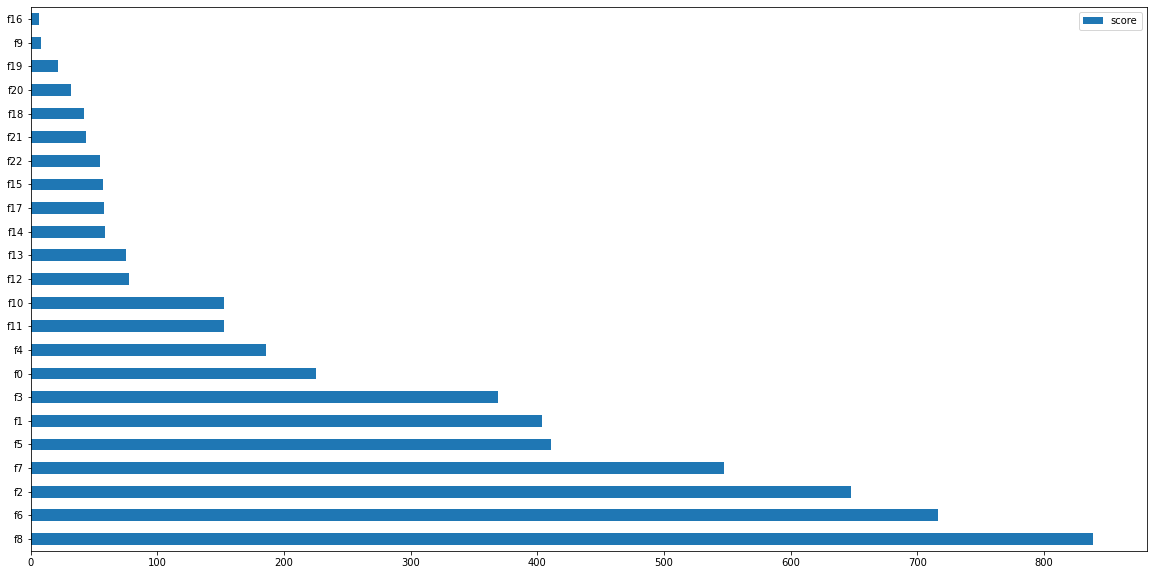

In [387]:
feature_important = my_xgbr.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features